In [1]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils

In [2]:
def color_grayscale_arr(arr, red=True):
  """Converts grayscale image to either red or green"""
  assert arr.ndim == 2
  dtype = arr.dtype
  h, w = arr.shape
  arr = np.reshape(arr, [h, w, 1])
  if red:
    arr = np.concatenate([arr,
                          np.zeros((h, w, 2), dtype=dtype)], axis=2)
  else:
    arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                          arr,
                          np.zeros((h, w, 1), dtype=dtype)], axis=2)
  return arr


class ColoredMNIST(datasets.VisionDataset):
  """
  Colored MNIST dataset for testing IRM. Prepared using procedure from https://arxiv.org/pdf/1907.02893.pdf

  Args:
    root (string): Root directory of dataset where ``ColoredMNIST/*.pt`` will exist.
    env (string): Which environment to load. Must be 1 of 'train1', 'train2', 'test', or 'all_train'.
    transform (callable, optional): A function/transform that  takes in an PIL image
      and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in the
      target and transforms it.
  """
  def __init__(self, root='./data', env='train1', transform=None, target_transform=None):
    super(ColoredMNIST, self).__init__(root, transform=transform,
                                target_transform=target_transform)

    self.prepare_colored_mnist()
    if env in ['train1', 'train2', 'test']:
      self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt')
    elif env == 'all_train':
      self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', 'train1.pt')) + \
                               torch.load(os.path.join(self.root, 'ColoredMNIST', 'train2.pt'))
    else:
      raise RuntimeError(f'{env} env unknown. Valid envs are train1, train2, test, and all_train')

  def __getitem__(self, index):
    """
    Args:
        index (int): Index

    Returns:
        tuple: (image, target) where target is index of the target class.
    """
    img, target = self.data_label_tuples[index]

    if self.transform is not None:
      img = self.transform(img)

    if self.target_transform is not None:
      target = self.target_transform(target)

    return img, target

  def __len__(self):
    return len(self.data_label_tuples)

  def prepare_colored_mnist(self):
    colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
    if os.path.exists(os.path.join(colored_mnist_dir, 'train1.pt')) \
        and os.path.exists(os.path.join(colored_mnist_dir, 'train2.pt')) \
        and os.path.exists(os.path.join(colored_mnist_dir, 'test.pt')):
      print('Colored MNIST dataset already exists')
      return

    print('Preparing Colored MNIST')
    train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True)

    train1_set = []
    train2_set = []
    test_set = []
    for idx, (im, label) in enumerate(train_mnist):
      if idx % 10000 == 0:
        print(f'Converting image {idx}/{len(train_mnist)}')
      im_array = np.array(im)

      # Assign a binary label y to the image based on the digit
      binary_label = 0 if label < 5 else 1

      # Flip label with 25% probability
      if np.random.uniform() < 0.25:
        binary_label = binary_label ^ 1

      # Color the image either red or green according to its possibly flipped label
      color_red = binary_label == 0

      # Flip the color with a probability e that depends on the environment
      if idx < 20000:
        # 20% in the first training environment
        if np.random.uniform() < 0.2:
          color_red = not color_red
      elif idx < 40000:
        # 10% in the first training environment
        if np.random.uniform() < 0.1:
          color_red = not color_red
      else:
        # 90% in the test environment
        if np.random.uniform() < 0.9:
          color_red = not color_red

      colored_arr = color_grayscale_arr(im_array, red=color_red)

      if idx < 20000:
        train1_set.append((Image.fromarray(colored_arr), binary_label))
      elif idx < 40000:
        train2_set.append((Image.fromarray(colored_arr), binary_label))
      else:
        test_set.append((Image.fromarray(colored_arr), binary_label))

      # Debug
      # print('original label', type(label), label)
      # print('binary label', binary_label)
      # print('assigned color', 'red' if color_red else 'green')
      # plt.imshow(colored_arr)
      # plt.show()
      # break

    if not os.path.exists(colored_mnist_dir):
      os.makedirs(colored_mnist_dir)
    torch.save(train1_set, os.path.join(colored_mnist_dir, 'train1.pt'))
    torch.save(train2_set, os.path.join(colored_mnist_dir, 'train2.pt'))
    torch.save(test_set, os.path.join(colored_mnist_dir, 'test.pt'))

In [3]:
def plot_dataset_digits(dataset):
  fig = plt.figure(figsize=(13, 8))
  columns = 6
  rows = 3
  # ax enables access to manipulate each of subplots
  ax = []

  for i in range(columns * rows):
    img, label = dataset[i]
    # create subplot and append to ax
    ax.append(fig.add_subplot(rows, columns, i + 1))
    ax[-1].set_title("Label: " + str(label))  # set title
    plt.imshow(img)

  plt.show()  # finally, render the plot
  

Colored MNIST dataset already exists


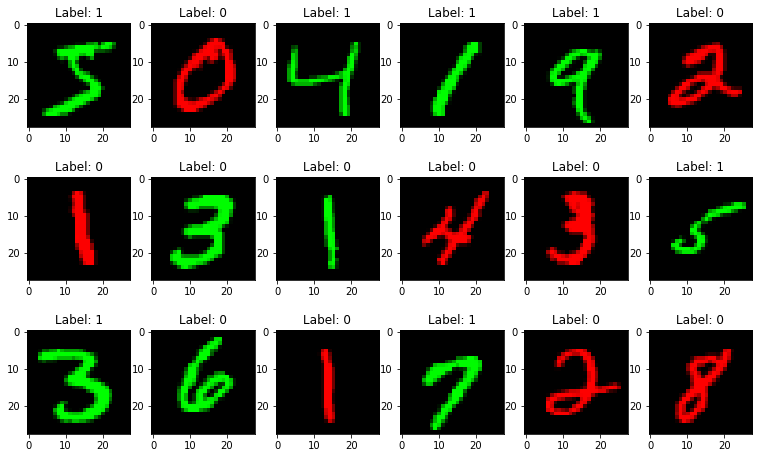

In [4]:
train1_set = ColoredMNIST(root='./data', env='train1')
plot_dataset_digits(train1_set)

Colored MNIST dataset already exists


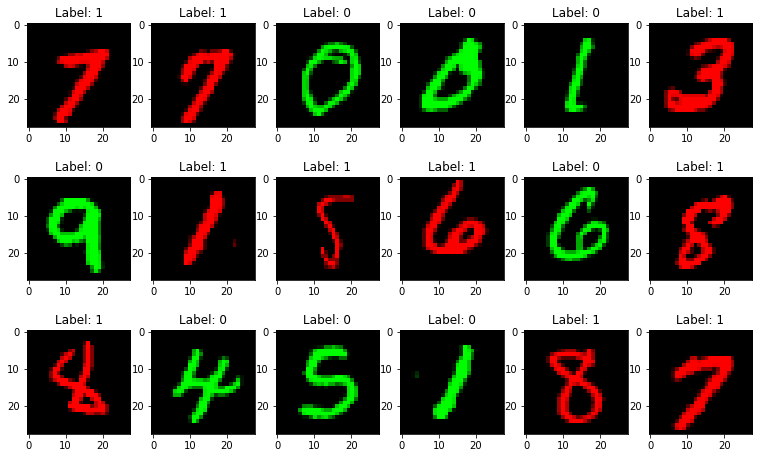

In [5]:
test_set = ColoredMNIST(root='./data', env='test')
plot_dataset_digits(test_set)

In [6]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(3 * 28 * 28, 512)
    self.fc2 = nn.Linear(512, 512)
    self.fc3 = nn.Linear(512, 1)

  def forward(self, x):
    x = x.view(-1, 3 * 28 * 28)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    logits = self.fc3(x).flatten()
    return logits


class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 20, 5, 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4 * 4 * 50, 500)
    self.fc2 = nn.Linear(500, 1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4 * 4 * 50)
    x = F.relu(self.fc1(x))
    logits = self.fc2(x).flatten()
    return logits

In [7]:
def test_model(model, device, test_loader, set_name="test set"):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device).float()
      output = model(data)
      test_loss += F.binary_cross_entropy_with_logits(output, target, reduction='sum').item()  # sum up batch loss
      pred = torch.where(torch.gt(output, torch.Tensor([0.0]).to(device)),
                         torch.Tensor([1.0]).to(device),
                         torch.Tensor([0.0]).to(device))  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)

  print('\nPerformance on {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    set_name, test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

  return 100. * correct / len(test_loader.dataset)


def erm_train(model, device, train_loader, optimizer, epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device).float()
    optimizer.zero_grad()
    output = model(data)
    loss = F.binary_cross_entropy_with_logits(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
               100. * batch_idx / len(train_loader), loss.item()))


def train_and_test_erm():
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
  all_train_loader = torch.utils.data.DataLoader(
    ColoredMNIST(root='./data', env='all_train',
                 transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
                   ])),
    batch_size=64, shuffle=True, **kwargs)

  test_loader = torch.utils.data.DataLoader(
    ColoredMNIST(root='./data', env='test', transform=transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
    ])),
    batch_size=1000, shuffle=True, **kwargs)

  model = ConvNet().to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.01)

  for epoch in range(1, 30):
    erm_train(model, device, all_train_loader, optimizer, epoch)
    test_model(model, device, all_train_loader, set_name='train set')
    test_model(model, device, test_loader)

train_and_test_erm()

Colored MNIST dataset already exists
Colored MNIST dataset already exists
Train Epoch: 1 [0/40000 (0%)]	Loss: 0.696403
Train Epoch: 1 [640/40000 (2%)]	Loss: 0.537798
Train Epoch: 1 [1280/40000 (3%)]	Loss: 0.560925
Train Epoch: 1 [1920/40000 (5%)]	Loss: 0.519479
Train Epoch: 1 [2560/40000 (6%)]	Loss: 0.483404
Train Epoch: 1 [3200/40000 (8%)]	Loss: 0.521695
Train Epoch: 1 [3840/40000 (10%)]	Loss: 0.493725
Train Epoch: 1 [4480/40000 (11%)]	Loss: 0.447846
Train Epoch: 1 [5120/40000 (13%)]	Loss: 0.351262
Train Epoch: 1 [5760/40000 (14%)]	Loss: 0.489206
Train Epoch: 1 [6400/40000 (16%)]	Loss: 0.484357
Train Epoch: 1 [7040/40000 (18%)]	Loss: 0.384684
Train Epoch: 1 [7680/40000 (19%)]	Loss: 0.419921
Train Epoch: 1 [8320/40000 (21%)]	Loss: 0.444990
Train Epoch: 1 [8960/40000 (22%)]	Loss: 0.390235
Train Epoch: 1 [9600/40000 (24%)]	Loss: 0.431205
Train Epoch: 1 [10240/40000 (26%)]	Loss: 0.481144
Train Epoch: 1 [10880/40000 (27%)]	Loss: 0.467739


KeyboardInterrupt: ignored

In [8]:
def calculate_vrex_penalty(losses):

  losses = torch.tensor(losses)
  mean = losses.mean()
  penalty = ((losses - mean) ** 2).mean()
  return penalty

def VREx_train(model, device, train_loaders, optimizer, epoch):

  model.train()

  train_loaders = [iter(x) for x in train_loaders]
  
  batch_idx = 0
  penalty_weight = 10000
  penalty_anneal_iters = 40
  regularizer_weight = 0.001

  while True:
    
    optimizer.zero_grad()
    error = 0
    penalty = 0
    losses = []
    weight_norm = torch.tensor(0.).cuda()
    for loader in train_loaders:
      data, target = next(loader, (None, None))
      if data is None:
        return

      data, target = data.to(device), target.to(device)
      output = model(data)
      loss_erm = F.binary_cross_entropy_with_logits(output, target.float(), reduction = 'none')
      losses.append(loss_erm.mean())
      error += loss_erm.mean()

    #VREx_penalty = calculate_vrex_penalty(losses)
    VREx_penalty = torch.stack([losses[0], losses[1]]).std()**2
    p_weight = (penalty_weight if epoch >= penalty_anneal_iters else 1.0)
    
    for w in model.parameters():
      weight_norm += w.norm().pow(2)

    final_loss = error + p_weight * VREx_penalty + regularizer_weight * weight_norm
    if p_weight > 1.0:
      final_loss /= p_weight

    final_loss.backward()
    optimizer.step()
    if batch_idx % 2 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tFinal loss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loaders[0]),
               100. * batch_idx / len(train_loaders[0]), final_loss.item()))
      
    batch_idx += 1




In [9]:
def train_and_test_VREx():

  use_cuda = torch.cuda.is_available()
  device = torch.device('cuda' if use_cuda else 'cpu')

  kwargs = {'num_workers' : 1, 'pin_memory' : True} if use_cuda else {}
  
  train1_loader = torch.utils.data.DataLoader(
      ColoredMNIST(root = './data', env = 'train1',
                   transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
                   ])),
      batch_size = 2000,
      shuffle = True,
      **kwargs
  )

  train2_loader = torch.utils.data.DataLoader(
      ColoredMNIST(root = './data', env = 'train2',
                   transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
                   ])
                   ),
       batch_size = 2000,
       shuffle = True,
       **kwargs

  )

  test_loader = torch.utils.data.DataLoader(
      ColoredMNIST(root = './data', env = 'test',
                   transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
                   ])),
      batch_size = 1000,
      shuffle = True,
      **kwargs
  )

  model = ConvNet().to(device)
  optimizer = optim.Adam(model.parameters(), lr = 0.001)
  alpha = 0.2
  gamma = 0.1

  for epoch in range(1, 100):
    VREx_train(model, device, [train1_loader, train2_loader], optimizer, epoch)
    train1_acc = test_model(model, device, train1_loader, set_name = 'train1 set')
    train2_acc = test_model(model, device, train2_loader, set_name = 'train2 set')
    test_acc = test_model(model, device, test_loader)
    if train1_acc > 75 and train2_acc > 75 and test_acc > 70:
      print('found acceptable values. stopping training.')
      return


In [10]:
train_and_test_VREx()

Colored MNIST dataset already exists
Colored MNIST dataset already exists
Colored MNIST dataset already exists
Train Epoch: 1 [0/10 (0%)]	Final loss: 1.589984
Train Epoch: 1 [4000/10 (20%)]	Final loss: 1.123877
Train Epoch: 1 [8000/10 (40%)]	Final loss: 1.192150
Train Epoch: 1 [12000/10 (60%)]	Final loss: 1.078732
Train Epoch: 1 [16000/10 (80%)]	Final loss: 0.999486

Performance on train1 set: Average loss: 0.5035, Accuracy: 15963/20000 (79.81%)


Performance on train2 set: Average loss: 0.3770, Accuracy: 17970/20000 (89.85%)


Performance on test set: Average loss: 1.3767, Accuracy: 2018/20000 (10.09%)

Train Epoch: 2 [0/10 (0%)]	Final loss: 1.045393
Train Epoch: 2 [4000/10 (20%)]	Final loss: 1.004841
Train Epoch: 2 [8000/10 (40%)]	Final loss: 0.962440
Train Epoch: 2 [12000/10 (60%)]	Final loss: 0.986197
Train Epoch: 2 [16000/10 (80%)]	Final loss: 0.985666

Performance on train1 set: Average loss: 0.4886, Accuracy: 15970/20000 (79.85%)


Performance on train2 set: Average loss: 0.3280